<a href="https://colab.research.google.com/github/RaianaSeixas/Genial_testes/blob/main/07_Estudo_de_caso_Genial_Invest_Raiana_bigtree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Resumo do estudo de caso**

Este estudo de caso é um problema de classificação composto de uma variável binária que deve ser avaliada por aprendizado supervisionado, sendo que são oito as variáveis independentes.

Existe duas classes que estão relativamente balanceadas (% up= 42.45 e % down= 57.55) e 45312 registros  sem nenhuma informação ausente para as variáveis envolvidas. Assim, a acurácia é um bom comparativo entre modelos e não há a necessidade de amostragem para balancear as classes, ou seja uma amostragem aleatória com 70% dos dados para treino e 30% para teste é suficiente. 

A comparação entre os modelos Random Forest, árvore de decisão, regressão logística e XGBoost e LigthGBM sugere que o modelo Random Forest (considerando os hiperparâmetros padrões (defaut) destes modelos) é o mais promissor entre os modelos testados (acurácia e precisão em cerca de 90% sem otimização ou seleção de features)  e constitui uma boa escolha para um estudo mais detalhado. 

Após o ajuste dos hiperparâmetros do modelo Random Forest e seleção de variáveis, pôde-se obter um modelo Random Forest com hiperparâmetros otimizados e com 5 features (nswprice, date, nswdemand, period e day). A acurácia final obtida foi superior a 93%.




---


Criado por: Raiana Roland Seixas

10/06/2022

# **Bibliotecas usadas**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn import datasets as ds
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
import seaborn as sns

#**Coleta de dados**

In [ ]:
data = ds.fetch_openml(data_id=151, as_frame=True, return_X_y=True)

(

    pd.concat(data, axis=1)

    .assign(target=lambda x: (x['class']=='UP')*1)

)

,date,day,period,nswprice,nswdemand,vicprice,vicdemand,transfer,class,target
0,0.0000,2,0.000000,0.056443,0.439155,0.003467,0.422915,0.414912,UP,1
1,0.0000,2,0.021277,0.051699,0.415055,0.003467,0.422915,0.414912,UP,1
2,0.0000,2,0.042553,0.051489,0.385004,0.003467,0.422915,0.414912,UP,1
3,0.0000,2,0.063830,0.045485,0.314639,0.003467,0.422915,0.414912,UP,1
4,0.0000,2,0.085106,0.042482,0.251116,0.003467,0.422915,0.414912,DOWN,0
...,...,...,...,...,...,...,...,...,...,...
45307,0.9158,7,0.914894,0.044224,0.340672,0.003033,0.255049,0.405263,DOWN,0
45308,0.9158,7,0.936170,0.044884,0.355549,0.003072,0.241326,0.420614,DOWN,0
45309,0.9158,7,0.957447,0.043593,0.340970,0.002983,0.247799,0.362281,DOWN,0
45310,0.9158,7,0.978723,0.066651,0.329366,0.004630,0.345417,0.206579,UP,1


Trata-se de um problema de classificação binária.

# **Pré-processamento**

In [ ]:
type(data)

tuple

In [ ]:
# Obteção das variáveis de entrada (features)
X=pd.DataFrame(data[0])

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45312 entries, 0 to 45311
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   date       45312 non-null  float64 
 1   day        45312 non-null  category
 2   period     45312 non-null  float64 
 3   nswprice   45312 non-null  float64 
 4   nswdemand  45312 non-null  float64 
 5   vicprice   45312 non-null  float64 
 6   vicdemand  45312 non-null  float64 
 7   transfer   45312 non-null  float64 
dtypes: category(1), float64(7)
memory usage: 2.5 MB


In [ ]:
# Os dados da coluna " day" estão salvos como texto. Vamos transformá-los em inteiros para serem processados por todos modelos
X['day'] = X['day'].astype(int)

In [ ]:
# Obtenção das saídas (targets)
target = pd.DataFrame(data[1])

# Transformar dados categóricos em 0 e 1
y = pd.DataFrame(data[1]) # apenas para manter o target de
y['class'].replace(['UP', 'DOWN'],[1,0], inplace=True) 
y.head()

,class
0,1
1,1
2,1
3,1
4,0


In [ ]:
# Obteção de um único dataframe com entratas e saídas (para EDA)
total_data=pd.concat([X, y], axis=1)
total_data.head()

,date,day,period,nswprice,nswdemand,vicprice,vicdemand,transfer,class
0,0.0,2,0.000000,0.056443,0.439155,0.003467,0.422915,0.414912,1
1,0.0,2,0.021277,0.051699,0.415055,0.003467,0.422915,0.414912,1
2,0.0,2,0.042553,0.051489,0.385004,0.003467,0.422915,0.414912,1
3,0.0,2,0.063830,0.045485,0.314639,0.003467,0.422915,0.414912,1
4,0.0,2,0.085106,0.042482,0.251116,0.003467,0.422915,0.414912,0




# **Análise exploratória dos dados (EDA)**

In [ ]:
total_data.describe() 

,date,day,period,nswprice,nswdemand,vicprice,vicdemand,transfer,class
count,45312.000000,45312.000000,45312.000000,45312.000000,45312.000000,45312.000000,45312.000000,45312.000000,45312.000000
mean,0.499080,4.003178,0.500000,0.057868,0.425418,0.003467,0.422915,0.500526,0.424545
std,0.340308,1.998695,0.294756,0.039991,0.163323,0.010213,0.120965,0.153373,0.494279
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.031934,2.000000,0.250000,0.035127,0.309134,0.002277,0.372346,0.414912,0.000000
50%,0.456329,4.000000,0.500000,0.048652,0.443693,0.003467,0.422915,0.414912,0.000000
75%,0.880547,6.000000,0.750000,0.074336,0.536001,0.003467,0.469252,0.605702,1.000000
max,1.000000,7.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Pode-se observar o banco de dados tem 45312 amostras e oito features.
Todos dados, exceto day, já estão escalonados. 

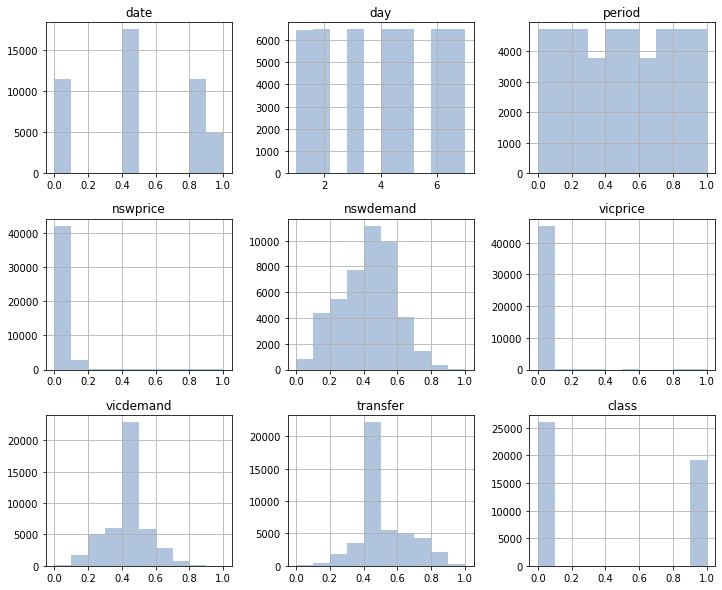

In [ ]:
# Distribuíção de frequências das variáveis
total_data.hist(figsize=(12,10),color='lightsteelblue');

Pode-se observar que as diferentes features possuem diferentes distribuições de frequência, sendo que algumas delas estão homogeneamente distribuídas, outras estão próximas da distribuição normal e outras estão bastante concentradas em uma única região.

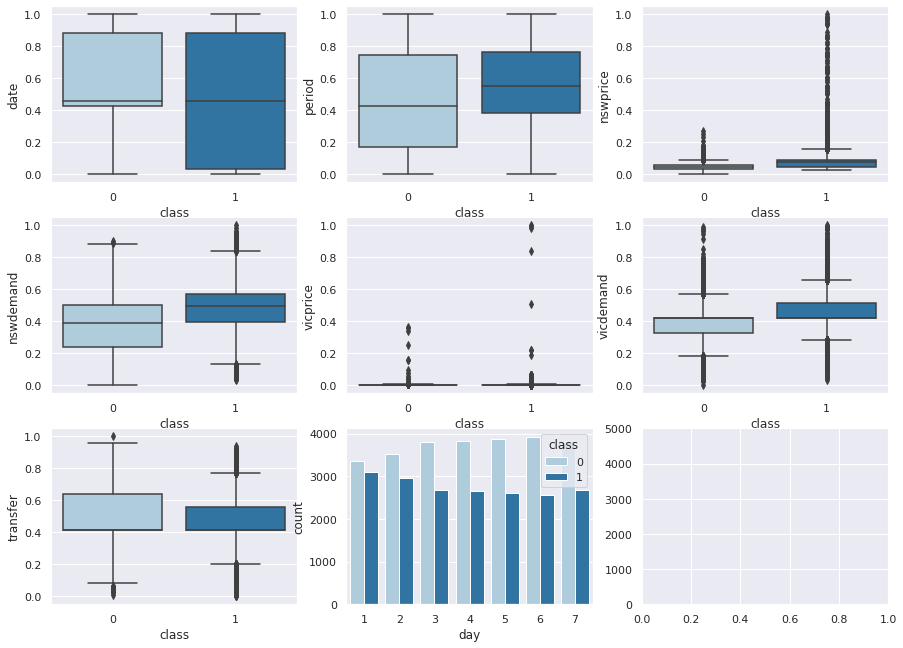

In [ ]:
sns.set()
fig, axes = plt.subplots(3, 3, figsize=(15, 11), sharey=False)
z = 0;i, j = divmod(z, 3);plt.ylim([0,1])
sns.boxplot(ax=axes[i,j], y = 'date', x = 'class', data = total_data,  palette="Paired")
z = z +1;i, j = divmod(z, 3);plt.ylim([0,1])
sns.boxplot(ax=axes[i,j],y = 'period', x = 'class', data = total_data, palette="Paired")
z = z +1; i, j = divmod(z, 3);plt.ylim([0,1])
sns.boxplot(ax=axes[i,j],y = 'nswprice', x = 'class', data = total_data, palette="Paired") 
z = z +1; i, j = divmod(z, 3);plt.ylim([0,1])
sns.boxplot(ax=axes[i,j],y = 'nswdemand', x = 'class', data = total_data, palette="Paired")
z = z +1; i, j = divmod(z, 3);plt.ylim([0,1]) 
sns.boxplot(ax=axes[i,j],y = 'vicprice', x = 'class', data = total_data,  palette="Paired")
z = z +1; i, j = divmod(z, 3);plt.ylim([0,1])
sns.boxplot(ax=axes[i,j],y = 'vicdemand', x = 'class', data = total_data,  palette="Paired") 
z = z +1; i, j = divmod(z, 3);plt.ylim([0,1])
sns.boxplot(ax=axes[i,j],y = 'transfer', x = 'class', data = total_data,  palette="Paired")
z = z +1; i, j = divmod(z, 3);plt.ylim([0,5000])
sns.countplot(ax=axes[i,j],x = 'day', hue = 'class', data = total_data, palette="Paired")

De modo geral, os valores para a classe 1 (up) são maiores que para a classe o (down), conforme pode ser observado nos boxplot.

Algumas features possuem muitos outliers, mas sem saber conhecer as características do problema é ´dificil decidir se é necessário, ou não algum tipo de tratamento.

In [ ]:
# Porcentagem entre as classes 
# up=1 down =0
up=total_data['class'].sum()/total_data['class'].count()
print('% up=',up*100)
print('% down=',(1-up)*100)

% up= 42.45453742937853
% down= 57.545462570621474


Classes estão relativamente balanceadas. Neste contexto, acurácia é um bom comparativo entre modelos.

# **Escolha do Modelo**

Vamos testar os dados com alguns algorítimos adequados para classificação binária supervisionada, usando os hyperparâmetros defaut dos métodos, e o mesmo random_state=111  para limitar o efeito da aleatoredade na performance. Em seguida, vamos calcular as métricas de desempenho e selecionar o modelo mais promissor de acordo com a acurácia para prosseguir a análise.

In [ ]:
# Escalonando o modelo
scaler_x = MinMaxScaler().fit(X)
scaler_y = MinMaxScaler().fit(y)
Xscale=scaler_x.transform(X)
yscale=scaler_y.transform(y)

In [ ]:
# Separação dos dados em treino e teste
X_train, X_test, y_train, y_test = \
    train_test_split(Xscale, yscale, test_size=0.30,  random_state=None, shuffle=True) # ps: shuffle= True default
    #train_test_split(Xscale, yscale, test_size=0.30,  random_state=111, shuffle=True) # ps: shuffle= True default

### Randon Forest

In [ ]:
#rf = RandomForestClassifier(random_state=111) # create model
rf = RandomForestClassifier(random_state=None) # create model
rf.fit(X_train, y_train) # training model
y_pred = rf.predict(X_test) #prediction step
y_pred_train = rf.predict(X_train) #prediction train step

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# Entendimento do efeito das variáveis de entrada

print('*********** Efeito das variáveis de entrada (features)  ***********')
print()
ft_imp = pd.Series(rf.feature_importances_).sort_values(ascending=False) #obtenção dos efeitos
#Renomenando os índices:
df0=pd.DataFrame(ft_imp)
df0.index = X.columns[ft_imp.index]
#Renomeando a coluna:
df0.columns=['Effect'] 
df0

*********** Efeito das variáveis de entrada (features)  ***********



,Effect
nswprice,0.310425
date,0.174133
nswdemand,0.129158
vicprice,0.110190
period,0.103767
vicdemand,0.062729
day,0.055072
transfer,0.054525


### Árvore de decisão

In [ ]:
#dt = tree.DecisionTreeClassifier( random_state=111) # create model
dt = tree.DecisionTreeClassifier( random_state=None) 
dt.fit(X_train, y_train) # training model
y_pred_dt = dt.predict(X_test) #prediction step
y_pred_train_dt = dt.predict(X_train)  #prediction train step

### Regressão Logística

In [ ]:
#lr= LogisticRegression( random_state=111) # create model
lr= LogisticRegression( random_state=None)
lr.fit(X_train, y_train) # training model
y_pred_lr = lr.predict(X_test) #prediction step
y_pred_train_lr = lr.predict(X_train)  #prediction train step

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### XGBoost

In [ ]:
#xgb = XGBClassifier(random_state=111) # create model
xgb = XGBClassifier()
xgb.fit(X_train, y_train) # training model
y_pred_xgb = xgb.predict(X_test) # predição teste
y_pred_train_xgb = xgb.predict(X_train)  # predição treino

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### LightGBM

In [ ]:
#LiGBM = LGBMClassifier(random_state=111) # create model
LiGBM = LGBMClassifier(random_state=None) # create model
LiGBM.fit(X_train, y_train) # training model
y_pred_lgbm = LiGBM.predict(X_test) #prediction step
y_pred_train_lgbm = LiGBM.predict(X_train)  #prediction train step

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### **Avaliação e comparação das métricas dos modelos**

In [ ]:
# Função que retorna todas métricas para os valores preditos dos modelos 
# será usada tanto para o conjunto treino como para o teste 
rowsNAMES = ['random forest','Decision Tree','Logistic Regression','modelo XGB',
         'light GBM']

colsNAMES = ['acurácia','precisão','recall','f1 score']

def resultsCLASSIFICA(y,ycalc):
  listMETRICS = []
  acc = accuracy_score(y, ycalc)
  listMETRICS.append(acc)
  prec = precision_score(y, ycalc)
  listMETRICS.append(prec)
  recall = recall_score(y, ycalc)
  listMETRICS.append(recall)
  f1 = f1_score(y, ycalc)
  listMETRICS.append(f1)

  return listMETRICS

In [ ]:
print('Avaliação das métricas do conjunto treino por modelo')

matMETRICS =[]

# random forest:
matMETRICS.append(resultsCLASSIFICA(y_train,y_pred_train))

# decision tree
matMETRICS.append(resultsCLASSIFICA(y_train,y_pred_train_dt))

#logistic regression
matMETRICS.append(resultsCLASSIFICA(y_train,y_pred_train_lr))

#XGB
matMETRICS.append(resultsCLASSIFICA(y_train,y_pred_train_xgb))

#lgbm
matMETRICS.append(resultsCLASSIFICA(y_train,y_pred_train_lgbm))


df = pd.DataFrame(matMETRICS)
df.index= rowsNAMES
df.columns =colsNAMES
df # modelos treino

Avaliação das métricas do conjunto treino por modelo


,acurácia,precisão,recall,f1 score
random forest,1.000000,1.000000,1.000000,1.000000
Decision Tree,1.000000,1.000000,1.000000,1.000000
Logistic Regression,0.752506,0.778185,0.583624,0.667006
modelo XGB,0.838609,0.837973,0.768614,0.801797
light GBM,0.898543,0.886701,0.872615,0.879602


In [ ]:
print('Avaliação das métricas do conjunto teste por modelo')

matMETRICS =[]

# random forest:
matMETRICS.append(resultsCLASSIFICA(y_test,y_pred))

# decision tree
matMETRICS.append(resultsCLASSIFICA(y_test,y_pred_dt))

#logistic regression
matMETRICS.append(resultsCLASSIFICA(y_test,y_pred_lr))

#XGB
matMETRICS.append(resultsCLASSIFICA(y_test,y_pred_xgb))

#lgbm
matMETRICS.append(resultsCLASSIFICA(y_test,y_pred_lgbm))

df = pd.DataFrame(matMETRICS)
df.index= rowsNAMES
df.columns =colsNAMES
df # modelos teste

Avaliação das métricas do conjunto teste por modelo


,acurácia,precisão,recall,f1 score
random forest,0.900839,0.897302,0.865245,0.880982
Decision Tree,0.887230,0.869953,0.863163,0.866545
Logistic Regression,0.750405,0.778195,0.575616,0.661749
modelo XGB,0.827865,0.826037,0.752688,0.787659
light GBM,0.878182,0.865139,0.844433,0.854660


Os resultados indicaram que random forest foi o modelo mais  promissor entre os testados (com acurácia no conjunto teste de cerca de 90%) e constitui uma boa escolha para um estudo mais detalhado. 

Obs: Apesar das métricas obtidas no conjunto treino serem iguais a 1, as métrícas obtidas no conjunto teste não indicam presença de overfitting.

# **Ajuste dos hiperpararâmetros do modelo selecionado - Random Forest**

Para favorecer a execução mais rápida  deste notebook, fez-se a etapa de otimização (ajuste) dos hiperparâmetros em notebook separado.
Os códigos comentados são exemplos de código utilizado nesta etapa.

Obs: Esta etapa poderia ser refinada. Devido ao aspecto altamente combinatório deste tipo de problema, foi feita uma primeira otimização considerando apenas 2 variáveis (max_features e criterion). Obteve-se que o número de features a ser considerado ao procurar o melhor critério para divisão do nó é 7 das 8 entradas, e que a melhor maneira de avaliar a pureza do nó é a entropia. Testou-se então, com esses parâmetros fixados,  o melhor número de árvores do modelo (n_estimators) entre as opções (100, 200, e 300), obtendo-se n_estimators: 300.

Em seguida, feita uma segunda otimização com o objetivo de tentar  podar as árvores da random forest, considerando os hiperparâmetros já definidos (max_features: 7, criterion: 'entropy', n_estimators: 300) e variando max_depth, min_samples_split e min_samples_leaf. Foi obtido que a profundidade ideal considerando os parâmetros já fixados é de 30 (ao invés de None), bem como que o número mínimo de amostras necessárias para dividir um nó interno e o número mínimo de amostras necessárias para um nó folha devem permanecer conforme o defaut do método (min_samples_split: 2, min_samples_leaf: 1)

### Códigos e respostas obtidas para os hiperparâmetros 

In [ ]:
# Hyperparâmetros defaut RandomForestClassifier
'''
n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='sqrt',
max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)
'''

### Teste 1: 
'''
param_grid = {
    'max_features': [2,3,4,5,6,7,8], 
    'criterion' :['gini', 'entropy']
}

CV_rf = GridSearchCV(
    rf,
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc', 
    verbose=10, # if >3 : the fold and candidate parameter indexes are also displayed together with the starting time of the computation.
    n_jobs=1, #Number of jobs to run in parallel. 
)
#CV_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv= 5)
CV_rf.fit(X_train, y_train)
'''

### Teste 2
'''
# Number of trees in random forest
n_estimators=[300]

# Number of features to consider at every split
max_features = [7]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(20, 110, num = 10)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               }
print(random_grid)
'''

"\n# Number of trees in random forest\nn_estimators=[300]\n\n# Number of features to consider at every split\nmax_features = [7]\n\n# Maximum number of levels in tree\nmax_depth = [int(x) for x in np.linspace(20, 110, num = 10)]\nmax_depth.append(None)\n\n# Minimum number of samples required to split a node\nmin_samples_split = [2, 5, 10]\n\n# Minimum number of samples required at each leaf node\nmin_samples_leaf = [1, 2, 4]\n\n# Create the random grid\nrandom_grid = {'n_estimators': n_estimators,\n               'max_features': max_features,\n               'max_depth': max_depth,\n               'min_samples_split': min_samples_split,\n               'min_samples_leaf': min_samples_leaf,\n               }\nprint(random_grid)\n"

In [ ]:
# Resposta obtida do  GridSearchCV (teste 1)
'''
{'criterion': 'entropy', 'max_features': 7} 
'''

# Resposta obtida do RandomizedSearchCV (teste 2)
'''
{'bootstrap': True,
 'max_depth': 30,
 'max_features': 7,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 300}
 '''

"\n{'bootstrap': True,\n 'max_depth': 30,\n 'max_features': 7,\n 'min_samples_leaf': 1,\n 'min_samples_split': 2,\n 'n_estimators': 300}\n "

### Modelo otimizado

In [ ]:
# Modelo com parâmetros otimizados

#rf_tun=RandomForestClassifier(random_state=111, max_features=7, criterion='entropy', max_depth= 30,n_estimators= 300) #defaut: n_estimators= 100 ; max_depthint:None ; min_samples_splitint: 2
rf_tun=RandomForestClassifier(random_state=None, max_features=7, criterion='entropy', max_depth= 30,n_estimators= 300) #defaut: n_estimators= 100 ; max_depthint:None ; min_samples_splitint: 2
rf_tun.fit(X_train, y_train)
y_pred = rf_tun.predict(X_test) #prediction step
y_pred_train = rf_tun.predict(X_train) #prediction train step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


In [ ]:
print('**********  Avaliação das métricas do modelo random forest após otimização ***********')
print('Conjunto Treino')
print()
print(" Acurácia: {0:.5f}".format(accuracy_score(y_train, y_pred_train)))
print(" Precisão: {0:.5f}".format(precision_score(y_train, y_pred_train)))
print("   Recall: {0:.5f}".format(recall_score(y_train, y_pred_train)))
print(" f1 score: {0:.5f}".format(f1_score(y_train, y_pred_train)))
print()
print('Conjunto Teste')
print()
print(" Acurácia: {0:.5f}".format(accuracy_score(y_test, y_pred)))
print(" Precisão: {0:.5f}".format(precision_score(y_test, y_pred)))
print("   Recall: {0:.5f}".format(recall_score(y_test, y_pred)))
print(" f1 score: {0:.5f}".format(f1_score(y_test, y_pred)))
print()

**********  Avaliação das métricas do modelo random forest após otimização ***********
Conjunto Treino

 Acurácia: 1.00000
 Precisão: 1.00000
   Recall: 1.00000
 f1 score: 1.00000

Conjunto Teste

 Acurácia: 0.92416
 Precisão: 0.91601
   Recall: 0.90409
 f1 score: 0.91001



Após a otimização, a acurácia do modelo passou de cerca de 90,4% para 92,8% no conjunto 
teste, representando um ganho superior a 2%




# **Features Selection**

In [ ]:
# Entendimento do efeito das variáveis de entrada

print('*********** Efeito das variáveis de entrada (features)  ***********')
print()
ft_imp = pd.Series(rf_tun.feature_importances_).sort_values(ascending=False) #obtenção dos efeitos
#Renomenando os índices:
df=pd.DataFrame(ft_imp)
df.index = X.columns[ft_imp.index]
#Renomeando a coluna:
df.columns=['Effect'] 
df

*********** Efeito das variáveis de entrada (features)  ***********



,Effect
nswprice,0.351998
date,0.249448
nswdemand,0.111386
period,0.077321
day,0.064212
vicprice,0.054863
vicdemand,0.045965
transfer,0.044807


In [ ]:
X_ord = X[df.index]
#X_ord = X
#y_ord= y[df.index] # new line

In [ ]:
#X_ord

Pode-se observar que o efeitos das features têm seus valores e ordem alterada com o modelo random forest antes e após a otimização dos parâmetros. Assim a otimização favorece uma melhor avaliação da importância das variáveis no estudo de caso e também pode impactar na seleção das mesmas para a construção de um modelo que melhor represente os dados. 

Text(0.5, 0, 'Efeito')

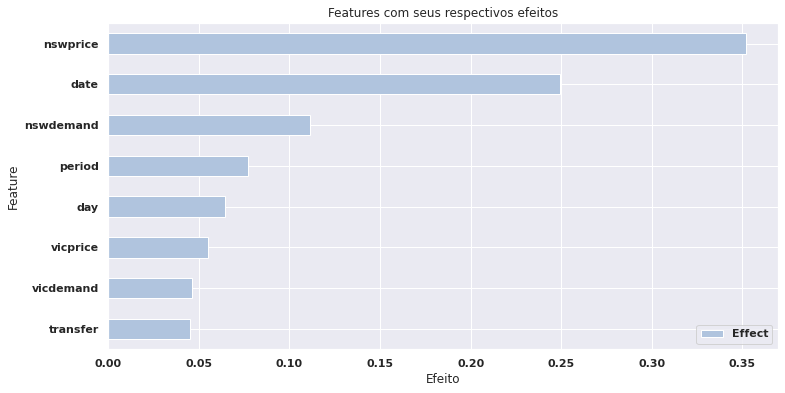

In [ ]:
# Vizualição da importância das Features

df1=df.sort_values(by=['Effect'], ascending=True) # sort in ascending order for plot

font = {'weight' : 'bold',
        'size'   : 12}

plt.rc('font', **font)
plt.rcParams['figure.figsize'] = [12, 6] 

df1.plot(kind='barh', color='lightsteelblue')
plt.title('Features com seus respectivos efeitos')
plt.ylabel('Feature')
plt.xlabel('Efeito')

In [ ]:
'''#Seleção de Variáveis
from sklearn.feature_selection import RFE
#features=X_train.shape[1]
rf_tun=RandomForestClassifier(random_state=None, max_features=None, criterion='entropy', max_depth= 30,n_estimators= 300) #defaut: n_estimators= 100 ; max_depthint:None ; min_samples_splitint: 2
rfe = RFE(rf_tun, n_features_to_select= 5) # Seleção de 5 variáveis
rfe = rfe.fit(X_train, y_train)
y_pred = rfe.predict(X_test) #prediction step
y_pred_train = rfe.predict(X_train) #prediction train step'''

"#Seleção de Variáveis\nfrom sklearn.feature_selection import RFE\n#features=X_train.shape[1]\nrf_tun=RandomForestClassifier(random_state=None, max_features=None, criterion='entropy', max_depth= 30,n_estimators= 300) #defaut: n_estimators= 100 ; max_depthint:None ; min_samples_splitint: 2\nrfe = RFE(rf_tun, n_features_to_select= 5) # Seleção de 5 variáveis\nrfe = rfe.fit(X_train, y_train)\ny_pred = rfe.predict(X_test) #prediction step\ny_pred_train = rfe.predict(X_train) #prediction train step"

In [ ]:
#rfe.feature_names_in_
#rfe.ranking_

In [ ]:
'''print('**********  Avaliação das métricas do modelo random forest após Seleção de variáveis ***********')
print('Conjunto Treino')
print()
print(" Acurácia: {0:.5f}".format(accuracy_score(y_train, y_pred_train)))
print(" Precisão: {0:.5f}".format(precision_score(y_train, y_pred_train)))
print("   Recall: {0:.5f}".format(recall_score(y_train, y_pred_train)))
print(" f1 score: {0:.5f}".format(f1_score(y_train, y_pred_train)))
print()
print('Conjunto Teste')
print()
print(" Acurácia: {0:.5f}".format(accuracy_score(y_test, y_pred)))
print(" Precisão: {0:.5f}".format(precision_score(y_test, y_pred)))
print("   Recall: {0:.5f}".format(recall_score(y_test, y_pred)))
print(" f1 score: {0:.5f}".format(f1_score(y_test, y_pred)))
print()'''

'print(\'**********  Avaliação das métricas do modelo random forest após Seleção de variáveis ***********\')\nprint(\'Conjunto Treino\')\nprint()\nprint(" Acurácia: {0:.5f}".format(accuracy_score(y_train, y_pred_train)))\nprint(" Precisão: {0:.5f}".format(precision_score(y_train, y_pred_train)))\nprint("   Recall: {0:.5f}".format(recall_score(y_train, y_pred_train)))\nprint(" f1 score: {0:.5f}".format(f1_score(y_train, y_pred_train)))\nprint()\nprint(\'Conjunto Teste\')\nprint()\nprint(" Acurácia: {0:.5f}".format(accuracy_score(y_test, y_pred)))\nprint(" Precisão: {0:.5f}".format(precision_score(y_test, y_pred)))\nprint("   Recall: {0:.5f}".format(recall_score(y_test, y_pred)))\nprint(" f1 score: {0:.5f}".format(f1_score(y_test, y_pred)))\nprint()'

In [ ]:
# Seleção das variáveis 
''' '''
def selectFEATURES(X_test, X_train,y_train):
  features=Xscale.shape[1]
  rf_tun=RandomForestClassifier(random_state=0, max_features=None, criterion='entropy', max_depth= 30,n_estimators= 300) 
  rf_tun.fit(X_train, y_train)
  y_pred_test = rf_tun.predict(X_test) #prediction step
  y_pred_train = rf_tun.predict(X_train) #prediction train step

  return y_pred_train, y_pred_test 

scaler_y = MinMaxScaler().fit(y)
yscale=scaler_y.transform(y)
scaler_x = MinMaxScaler().fit(X_ord)
XscaleALL=scaler_x.transform(X_ord)
acc_train = []; acc_test = []
precision_train=[]; precision_test=[]
recall_train=[]; recall_test=[]
f1_train=[]; f1_test=[]
best_feat = []

for features in range(2,9):
  Xscale = XscaleALL[:,:features]  # Selecionando as melhores features (Número total= 8)
  X_train, X_test, y_train, y_test = \
      train_test_split(Xscale, yscale, test_size=0.30, shuffle=True)  
  predict_train, predict_test = selectFEATURES(X_test, X_train, y_train)
  best_feat.append(features)
  acc_train.append(accuracy_score(y_train, predict_train))
  acc_test.append(accuracy_score(y_test, predict_test))
  precision_train.append(precision_score(y_train, predict_train))
  precision_test.append(precision_score(y_test, predict_test))
  recall_train.append(recall_score(y_train, predict_train))
  recall_test.append(recall_score(y_test, predict_test))
  f1_train.append(f1_score(y_train, predict_train))
  f1_test.append(f1_score(y_test, predict_test))
  
df1 =pd.DataFrame({'Features':best_feat, 'train acc':acc_train,
                 'test acc':acc_test,'train prec':precision_train,
                  'test prec':precision_test, 'train recall':recall_train,
                  'test recall':recall_test, 'train f1':f1_train,
                  'test f1':f1_test } )   
df1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was pas

,Features,train acc,test acc,train prec,test prec,train recall,test recall,train f1,test f1
0,2,0.987294,0.920995,0.985748,0.908820,0.984360,0.903759,0.985054,0.906283
1,3,0.999968,0.917905,1.000000,0.909780,0.999926,0.895266,0.999963,0.902465
2,4,1.000000,0.922245,1.000000,0.911012,1.000000,0.900850,1.000000,0.905902
3,5,1.000000,0.928130,1.000000,0.919151,1.000000,0.910370,1.000000,0.914740
4,6,1.000000,0.926880,1.000000,0.919240,1.000000,0.905736,1.000000,0.912438
5,7,1.000000,0.925555,1.000000,0.918155,1.000000,0.907455,1.000000,0.912774
6,8,1.000000,0.925850,1.000000,0.913645,1.000000,0.910138,1.000000,0.911888


Da seleção das variáveis de entrada, observa-se que o modelo com as 5 features de maior efeito (nswprice, date, nswdemand, period e day) apresentou a melhor acurácia. 

Após a etapa de feature selection, a acurácia do melhor modelo passou de  92,8% para 93,3% no conjunto teste, representando um ganho de a 0,5% em relação ao modelo pós otimização e cerca de 3% em relação ao modelo com os parâmetros defaut. 


Obs: Não foram fornecidos informações descrevendo as variáveis, sem isso não é possível considerar o entendimento do negócio para fazer uma análise mais detalhada.

In [ ]:
# Extract single tree
def selectRandomFOREST(X_test, X_train,y_train):
  features=Xscale.shape[1]
  rf_tun=RandomForestClassifier(random_state=None, max_features=5, 
                                criterion='entropy', max_depth= 30,
                                n_estimators= 1) 
  rf_tun.fit(X_train, y_train)
  return rf_tun

features = 5
Xscale = XscaleALL[:,:features]
X_train, X_test, y_train, y_test = \
      train_test_split(Xscale, yscale, test_size=0.30,random_state=0, shuffle=True)
X_ref = X_ord.iloc[:,:5]
nameREF = X_ref.columns
X_train = pd.DataFrame(X_train,columns=nameREF)
X_test = pd.DataFrame(X_test,columns=nameREF)
rfe = selectRandomFOREST(X_test, X_train,y_train)
estimator = rfe.estimators_[0]

'''from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = X_ord.columns[:features],
                class_names = ['UP','DOWN'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)
                
# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')'''

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


"from sklearn.tree import export_graphviz\n# Export as dot file\nexport_graphviz(estimator, out_file='tree.dot', \n                feature_names = X_ord.columns[:features],\n                class_names = ['UP','DOWN'],\n                rounded = True, proportion = False, \n                precision = 2, filled = True)\n                \n# Convert to png using system command (requires Graphviz)\nfrom subprocess import call\ncall(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])\n\n# Display in jupyter notebook\nfrom IPython.display import Image\nImage(filename = 'tree.png')"

In [ ]:
rfe

RandomForestClassifier(criterion='entropy', max_depth=30, max_features=5,
                       n_estimators=1)

In [ ]:
X_ref = X_ord.iloc[:,:5]
nameREF = X_ref.columns
classNAME = ['DOWN','UP']

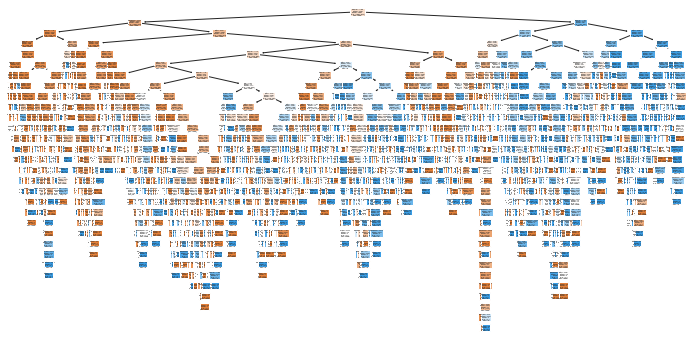

In [ ]:
tree.plot_tree(rfe.estimators_[0],
               feature_names = nameREF, 
               class_names=classNAME,
               filled = True);

In [ ]:
X_ord.columns

Index(['nswprice', 'date', 'nswdemand', 'period', 'day', 'vicprice',
       'vicdemand', 'transfer'],
      dtype='object')

In [ ]:
# Extract single tree
def selectRandomFOREST(X_test, X_train,y_train):
  features=Xscale.shape[1]
  rf_tun=RandomForestClassifier(random_state=None, max_features=5, 
                                criterion='entropy', max_depth= 30,
                                n_estimators= 300) 
  rf_tun.fit(X_train, y_train)
  return rf_tun

features = 5
Xscale = XscaleALL[:,:features]
X_train, X_test, y_train, y_test = \
      train_test_split(Xscale, yscale, test_size=0.30,random_state=0, shuffle=True)
X_ref = X_ord.iloc[:,:5]
nameREF = X_ref.columns
X_train = pd.DataFrame(X_train,columns=nameREF)
X_test = pd.DataFrame(X_test,columns=nameREF)
rfe = selectRandomFOREST(X_test, X_train,y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


In [ ]:
# Entendimento do efeito das variáveis de entrada

print('*********** Efeito das variáveis de entrada (features)  ***********')
print()
ft_imp = pd.Series(rfe.feature_importances_).sort_values(ascending=False) #obtenção dos efeitos
#Renomenando os índices:
df=pd.DataFrame(ft_imp)
df.index = X_ord.columns[ft_imp.index]
#Renomeando a coluna:
df.columns=['Effect'] 
df

*********** Efeito das variáveis de entrada (features)  ***********



,Effect
nswprice,0.392348
date,0.307466
nswdemand,0.136282
period,0.088524
day,0.075380


Text(0.5, 0, 'Efeito')

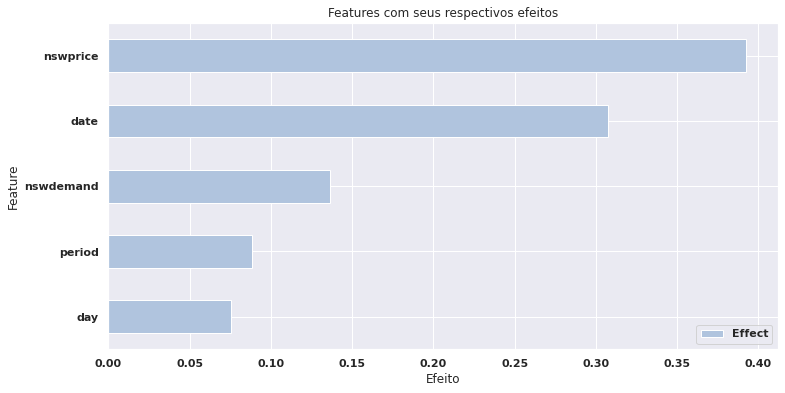

In [ ]:
# Vizualição da importância das Features

df1=df.sort_values(by=['Effect'], ascending=True) # sort in ascending order for plot

font = {'weight' : 'bold',
        'size'   : 12}

plt.rc('font', **font)
plt.rcParams['figure.figsize'] = [12, 6] 

df1.plot(kind='barh', color='lightsteelblue')
plt.title('Features com seus respectivos efeitos')
plt.ylabel('Feature')
plt.xlabel('Efeito')